<a href="https://colab.research.google.com/github/balajikulkarni/Jnana/blob/master/Augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Augmentation Policies:


1.   CutOut
2.   Random Crop and Pad
3.   Flip LR
4.   Rotate

Add new augmentations by defining new functions.
This file shows example usage of above augmentations.



In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

import math

In [0]:
#CUTOUT
def cutout(x, y, pad_size=4, replace=0):
    """
    Apply cutout (https://arxiv.org/abs/1708.04552) to image.
    This operation applies a (2*pad_size x 2*pad_size) mask of zeros to
    a random location within `img`. The pixel values filled in will be of the
    value `replace`. The located where the mask will be applied is randomly
    chosen uniformly over the whole image.
    
    Args:
    image: An image Tensor of type uint8.
    
    pad_size: Specifies how big the zero mask that will be generated is that
    is applied to the image. The mask will be of size
    (2*pad_size x 2*pad_size).
    replace: What pixel value to fill in the image in the area that has
    the cutout mask applied to it.
    Returns:
    	An image Tensor that is of type uint8.
    """
    image_height = tf.shape(x)[0]
    image_width = tf.shape(x)[1]
    
    # Sample the center location in the image where the zero mask will be applied.
    cutout_center_height = tf.random_uniform(
        shape=[], minval=0, maxval=image_height,
        dtype=tf.int32)
    
    cutout_center_width = tf.random_uniform(
        shape=[], minval=0, maxval=image_width,
        dtype=tf.int32)
    
    lower_pad = tf.maximum(0, cutout_center_height - pad_size)
    upper_pad = tf.maximum(0, image_height - cutout_center_height - pad_size)
    left_pad = tf.maximum(0, cutout_center_width - pad_size)
    right_pad = tf.maximum(0, image_width - cutout_center_width - pad_size)
    
    cutout_shape = [image_height - (lower_pad + upper_pad),
                    image_width - (left_pad + right_pad)]
    padding_dims = [[lower_pad, upper_pad], [left_pad, right_pad]]
    
    mask = tf.pad(
        tf.zeros(cutout_shape, dtype=image.dtype),
        padding_dims, constant_values=1)
    mask = tf.expand_dims(mask, -1)
    mask = tf.tile(mask, [1, 1, 3])
    
    image = tf.where(
        tf.equal(mask, 0),
        tf.ones_like(x, dtype=image.dtype) * replace,
        image)
		
    return x,y

#Horizontal-Flip
def flip_lr(x,y):
    """
    Randomly flip the image left and right.
    :param image: Input image.
    :return: Transformed image.
    """
    x = tf.image.random_flip_left_right(x)
    return x,y

#Random Pad-and-Crop
def random_pad_crop(x, y, pad_size=4):
    """
    Randomly pad the image by `pad_size` at each border (top, bottom, left, right).
    Then, crop the padded image to its original size.
    :param x: Input image.
    :param pad_size: Number of pixels to pad at each border. For example, a 32x32 image padded with 4 pixels becomes a
                     40x40 image. Then, the subsequent cropping step crops the image back to 32x32. Padding is done in
                     `reflect` mode.
    :return: Transformed image.
    """
    shape = tf.shape(x)
    x = tf.pad(x, [[pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='reflect')
    x = tf.random_crop(x, [shape[0], shape[1], 3])
    return x, y

#Rotate
def rotate(x, y, angle=30):
    """
    Rotates a given image by 'angle'.
    """
    x = tf.contrib.image.rotate(x, math.radians(angle))
    return x,y

## Usage Example as below

In [0]:

#Example values
rotate_angle = 30
mask = 4
pad_size = 4


#Utility to plot the images
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

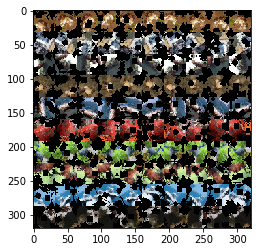

In [15]:
# Augment 10 samples
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

data = (x_train[0:10] / 255).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)

for f in augmentations:
    dataset = dataset.map(lambda x: cutout(flip_lr(random_pad_crop(rotate(x, rotate_angle), pad_size)), mask), num_parallel_calls=4)

plot_images(dataset, n_images=10, samples_per_image=10)